# M.Sc / Internship Project

## Project title:
Use of High-Resolution Aerosol Optical Depth (AOD) Data for Identification of Fine Particulates and Local-Level Pollution Sources in the Ambient Environment of Delhi

### Pre requisite

In [4]:
import warnings 
warnings.filterwarnings(action="ignore")

### DATA INGESTION collected from NASA LAADS DAAC site manually

In [ ]:
from pyhdf import SD
hdf_file_path = 'c:/Users/kaila/Downloads/MCD19A2.A2022315.h24v06.061.2023012193614.hdf'
try:
    hdf = SD.SD(hdf_file_path)
except Exception as e:
    print('Unable to open file: \n' + hdf_file_path')
    print('Error:', e)
    exit()
datasets = hdf.datasets()
for i, item in enumerate(datasets.items()):
    key, value = item[0], item[1]
    spatres = value[0]  
    if any("1km" in name for name in spatres):
        print('{0}: {1}'.format(i + 1, key))
print('All valid files in the directory have been processed')

# HDF TO CSV(manually all files one by one)

In [ ]:
from pyhdf import SD
import numpy as np
import time
import sys
import pyproj
from collections import OrderedDict
def parse_hdfeos_metadata(string):
    out = OrderedDict()
    lines = [i.replace('\t', '') for i in string.split('\n')]
    i = -1
    while i < (len(lines)) - 1:
        i += 1
        line = lines[i]
        if "=" in line:
            key, value = line.split('=')
            if key in ['GROUP', 'OBJECT']:
                endIdx = lines.index('END_{}={}'.format(key, value))
                out[value] = parse_hdfeos_metadata("\n".join(lines[i + 1:endIdx]))
                i = endIdx
            else:
                if ('END_GROUP' not in key) and ('END_OBJECT' not in key):
                    try:
                        out[key] = eval(value)
                    except NameError:
                        out[key] = str(value)
    return out
def construct_coords(ds, grid='GRID_1'):
    attrs = ds.attributes()
    metadata = parse_hdfeos_metadata(attrs['StructMetadata.0'])
    gridInfo = metadata['GridStructure'][grid]
    x1, y1 = gridInfo['UpperLeftPointMtrs']
    x2, y2 = gridInfo['LowerRightMtrs']
    yRes = (y1 - y2) / gridInfo['YDim']
    xRes = (x1 - x2) / gridInfo['XDim']
    x = np.arange(x2, x1, xRes)
    y = np.arange(y2, y1, yRes)[::-1]
    xx, yy = np.meshgrid(x, y)
    if 'soid' in gridInfo['Projection'].lower():
        pp = 'sinu'
    else:
        pp = gridInfo['Projection'].lower()    
    projStr = "+proj={} +lon_0=0 +x_0=0 +y_0=0 +a={} +units=m +no_defs".format(
      pp, gridInfo['ProjParams'][0])
    proj = pyproj.Proj(projStr)
    gcs = proj.to_latlong()
    lon, lat = pyproj.transform(proj, gcs, xx, yy)
    return lon, lat
file_path = 'C:/Users/kaila/Downloads/MCD19A2.A2023090.h24v06.061.2023092162323.hdf'
try:
    hdf = SD.SD(file_path)
except Exception as e:
    print('Unable to open file: \n' + file_path + '\nSkipping...')
    print('Error:', e)
    sys.exit()
dataFields = {
    1: 'Optical_Depth_047',
    2: 'Optical_Depth_055'
}
lon, lat = construct_coords(hdf)
latitude = lat.ravel()
longitude = lon.ravel()
attrs = hdf.attributes()
scan_time = np.array((attrs['Orbit_time_stamp']).split())
year = np.zeros(scan_time.shape[0])
month = np.zeros(scan_time.shape[0])
day = np.zeros(scan_time.shape[0])
hour = np.zeros(scan_time.shape[0])
minute = np.zeros(scan_time.shape[0])
sensor = np.zeros(scan_time.shape[0], dtype=object)
sensor_lookup = {'T': 'Terra', 'A': 'Aqua'}
orbit = np.zeros(scan_time.shape[0]) 
for i in range(scan_time.shape[0]):
    st = scan_time[i - 1]
    temp = time.strptime(st[:-1], "%Y%j%H%M")
    year[i - 1] = temp[0]
    month[i - 1] = temp[1]
    day[i - 1] = temp[2]
    hour[i - 1] = temp[3]
    minute[i - 1] = temp[4]
    sensor[i - 1] = sensor_lookup[st[-1]]
    orbit[i] = i + 1
end = 9 + len(dataFields)
output = np.array(np.zeros((year.shape[0] * lat.size, end)), dtype='O')
tempOutput = ['Year', 'Month', 'Day', 'Hour', 'Minute', 'Sensor', 'Orbit', 'Latitude', 'Longitude']
for i in range(9, end):
    SDS_NAME = dataFields[(i - 8)]
    try:
        sds = hdf.select(SDS_NAME)
    except:
        print('Hdf file does not contain the SDS:', SDS_NAME)
        sys.exit()
    attributes = sds.attributes()
    try:
        scale_factor = attributes['scale_factor']
    except KeyError:
        scale_factor = 1
    fillvalue = attributes['_FillValue']
    variable = sds.get()
    tempOutput.append(SDS_NAME)
    for j in range(scan_time.shape[0]):
        startIdx = j * lat.size
        endIdx = startIdx + lat.size
        output[startIdx:endIdx, 0] = int(year[j])
        output[startIdx:endIdx, 1] = int(month[j])
        output[startIdx:endIdx, 2] = int(day[j])
        output[startIdx:endIdx, 3] = int(hour[j])
        output[startIdx:endIdx, 4] = int(minute[j])
        output[startIdx:endIdx, 5] = sensor[j]
        output[startIdx:endIdx, 6] = int(orbit[j])
        output[startIdx:endIdx, 7] = latitude[:].astype(np.float32)
        output[startIdx:endIdx, 8] = longitude[:].astype(np.float32)
        data = np.array(variable[j, :, :].ravel())
        data = data.astype(float)
        data[data == float(fillvalue)] = np.nan
        data = data * scale_factor
        data[np.isnan(data)] = fillvalue
        output[startIdx:endIdx, i] = data
tempOutput = np.asarray(tempOutput)
output = np.row_stack((tempOutput, output))
output_file_path = file_path.replace('.hdf', '.csv')
np.savetxt(output_file_path, output, fmt='%s', delimiter=',')
print('\nData has been saved successfully to:', output_file_path)

In [ ]:
import pandas as pd
A=pd.read_csv("c:/Users/kaila/Downloads/MCD19A2.A2023090.h24v06.061.2023092162323.csv");A

In [ ]:
A=A[A["Optical_Depth_047"]!=-28672.0];A

# FILTER OF DATA BY COORDINATES

In [ ]:
A=A[(A['Latitude'] > 27.6581) & (A['Latitude'] < 29.113)]
A=A[(A['Longitude'] > 76.2781) & (A['Longitude'] < 78.0249)];A

# CSV OUTPUT 

In [ ]:
A.to_csv("C:/Users/kaila/OneDrive/Desktop/october2022/mar31.csv")

In [ ]:
A=pd.read_csv("C:/Users/kaila/OneDrive/Desktop/october2022/mar31.csv");A

# FILTERED DATA BY IITM COORDINATES

In [1]:
import os
import pandas as pd
input_directory = 'c:/Users/kaila/OneDrive/Desktop/october2022/'
output_directory = 'c:/Users/kaila/OneDrive/Desktop/new_data/'
latitude_min = 28.5962
latitude_max = 28.688
longitude_min = 77.1202
longitude_max = 77.230
for filename in os.listdir(input_directory):
    if filename.endswith('.csv'):
        filepath = os.path.join(input_directory, filename)
        df = pd.read_csv(filepath)
        filtered_df = df[(df['Latitude'] > latitude_min) & (df['Latitude'] < latitude_max) &
                         (df['Longitude'] > longitude_min) & (df['Longitude'] < longitude_max)]
        output_filepath = os.path.join(output_directory, filename)
        filtered_df.to_csv(output_filepath, index=False)
        print(f"data saved to: {output_filepath}")

Filtered data saved to: c:/Users/kaila/OneDrive/Desktop/new data/dec1.csv
Filtered data saved to: c:/Users/kaila/OneDrive/Desktop/new data/dec10.csv
Filtered data saved to: c:/Users/kaila/OneDrive/Desktop/new data/dec11.csv
Filtered data saved to: c:/Users/kaila/OneDrive/Desktop/new data/dec12.csv
Filtered data saved to: c:/Users/kaila/OneDrive/Desktop/new data/dec13.csv
Filtered data saved to: c:/Users/kaila/OneDrive/Desktop/new data/dec14.csv
Filtered data saved to: c:/Users/kaila/OneDrive/Desktop/new data/dec15.csv
Filtered data saved to: c:/Users/kaila/OneDrive/Desktop/new data/dec16.csv
Filtered data saved to: c:/Users/kaila/OneDrive/Desktop/new data/dec17.csv
Filtered data saved to: c:/Users/kaila/OneDrive/Desktop/new data/dec18.csv
Filtered data saved to: c:/Users/kaila/OneDrive/Desktop/new data/dec19.csv
Filtered data saved to: c:/Users/kaila/OneDrive/Desktop/new data/dec2.csv
Filtered data saved to: c:/Users/kaila/OneDrive/Desktop/new data/dec20.csv
Filtered data saved to: c:/

# TAKING AVERAGE OF OPTICAL DEPTH_470 OF ALL FILES

In [ ]:
import pandas as pd
import os
directory = "C:/Users/kaila/OneDrive/Desktop/new_data/"
average_values = []
for filename in os.listdir(directory):
    if filename.endswith(".csv"):
        df = pd.read_csv(os.path.join(directory, filename))
        average_optical_depth_047 = df['Optical_Depth_047'].mean()
        average_values.append({'Filename': filename, 'Average_Optical_Depth_047': average_optical_depth_047})
average_df = pd.DataFrame(average_values)
average_df.to_csv("C:/Users/kaila/OneDrive/Desktop/averages/average_Optical_Depth_047.csv", index=False)

# ARRANGE ALL FILES OF AVERAGES ACCORDING TO MONTHS

In [3]:
import pandas as pd
df = pd.read_csv('C:/Users/kaila/OneDrive/Desktop/averages/average_Optical_Depth_047.csv')
oct_data = df.filter(like='oct')
nov_data = df.filter(like='nov')
dec_data = df.filter(like='dec')
jan_data = df.filter(like='jan')
feb_data = df.filter(like='feb')
mar_data = df.filter(like='mar')
oct_data = oct_data.reindex(sorted(oct_data.columns, key=lambda x: int(x[3:])))
nov_data = nov_data.reindex(sorted(nov_data.columns, key=lambda x: int(x[3:])))
dec_data = dec_data.reindex(sorted(dec_data.columns, key=lambda x: int(x[3:])))
jan_data = jan_data.reindex(sorted(jan_data.columns, key=lambda x: int(x[3:])))
feb_data = feb_data.reindex(sorted(feb_data.columns, key=lambda x: int(x[3:])))
mar_data = mar_data.reindex(sorted(mar_data.columns, key=lambda x: int(x[3:])))
sorted_df = pd.concat([oct_data, nov_data, dec_data, jan_data, feb_data, mar_data], axis=1)
sorted_df.to_csv('C:/Users/kaila/OneDrive/Desktop/averages/sorted_data.csv', index=False)

# FINAL DATA

# IMPORT FINAL CSV FILE

In [5]:
import pandas as pd
A=pd.read_csv("FINAL_CSVFILE_OF_ALL_DATA.csv");A

,Unnamed: 0,DATE,AVERAGE OPTICAL_DEPTH_047,carbonaceous_aerosols_470(kg/m^3),average_merra2(kg/m^3)_(M2T1NXAER v5.12.4)
0,0,01-10-2022,0.188398,NaN,3.500000e-09
1,1,02-10-2022,0.242980,NaN,3.610000e-09
2,2,03-10-2022,0.222058,NaN,1.860000e-09
3,3,04-10-2022,0.373552,9.040000e-09,2.670000e-09
4,4,05-10-2022,0.278813,1.410000e-08,2.780000e-09
...,...,...,...,...,...
177,177,27-03-2023,0.454712,4.360000e-09,1.250000e-09
178,178,28-03-2023,0.548524,4.620000e-09,1.280000e-09
179,179,29-03-2023,0.580424,8.430000e-09,2.120000e-09
180,180,30-03-2023,NaN,8.550000e-09,2.420000e-09


# DROP NA VALUES

In [6]:
A=A.dropna();A

,Unnamed: 0,DATE,AVERAGE OPTICAL_DEPTH_047,carbonaceous_aerosols_470(kg/m^3),average_merra2(kg/m^3)_(M2T1NXAER v5.12.4)
3,3,04-10-2022,0.373552,9.040000e-09,2.670000e-09
4,4,05-10-2022,0.278813,1.410000e-08,2.780000e-09
5,5,06-10-2022,0.320570,1.490000e-09,1.670000e-09
6,6,07-10-2022,0.334944,1.720000e-09,3.850000e-09
7,7,08-10-2022,0.603907,2.200000e-09,5.890000e-09
...,...,...,...,...,...
176,176,26-03-2023,0.637345,4.110000e-09,1.270000e-09
177,177,27-03-2023,0.454712,4.360000e-09,1.250000e-09
178,178,28-03-2023,0.548524,4.620000e-09,1.280000e-09
179,179,29-03-2023,0.580424,8.430000e-09,2.120000e-09


# SCALING FACTOR FOR MERRA2 DATA

In [7]:
A['scaled_bc_mass_conc'] = A['average_merra2(kg/m^3)_(M2T1NXAER v5.12.4)'] / A['AVERAGE OPTICAL_DEPTH_047'];A

,Unnamed: 0,DATE,AVERAGE OPTICAL_DEPTH_047,carbonaceous_aerosols_470(kg/m^3),average_merra2(kg/m^3)_(M2T1NXAER v5.12.4),scaled_bc_mass_conc
3,3,04-10-2022,0.373552,9.040000e-09,2.670000e-09,7.147607e-09
4,4,05-10-2022,0.278813,1.410000e-08,2.780000e-09,9.970823e-09
5,5,06-10-2022,0.320570,1.490000e-09,1.670000e-09,5.209466e-09
6,6,07-10-2022,0.334944,1.720000e-09,3.850000e-09,1.149446e-08
7,7,08-10-2022,0.603907,2.200000e-09,5.890000e-09,9.753161e-09
...,...,...,...,...,...,...
176,176,26-03-2023,0.637345,4.110000e-09,1.270000e-09,1.992641e-09
177,177,27-03-2023,0.454712,4.360000e-09,1.250000e-09,2.748995e-09
178,178,28-03-2023,0.548524,4.620000e-09,1.280000e-09,2.333534e-09
179,179,29-03-2023,0.580424,8.430000e-09,2.120000e-09,3.652501e-09


# SCALING FACTOR FOR GROUND DATA

In [8]:
A['scaled_carbonaceous_aerosols_conc'] = A['carbonaceous_aerosols_470(kg/m^3)'] / A['AVERAGE OPTICAL_DEPTH_047'];A

,Unnamed: 0,DATE,AVERAGE OPTICAL_DEPTH_047,carbonaceous_aerosols_470(kg/m^3),average_merra2(kg/m^3)_(M2T1NXAER v5.12.4),scaled_bc_mass_conc,scaled_carbonaceous_aerosols_conc
3,3,04-10-2022,0.373552,9.040000e-09,2.670000e-09,7.147607e-09,2.420014e-08
4,4,05-10-2022,0.278813,1.410000e-08,2.780000e-09,9.970823e-09,5.057144e-08
5,5,06-10-2022,0.320570,1.490000e-09,1.670000e-09,5.209466e-09,4.647967e-09
6,6,07-10-2022,0.334944,1.720000e-09,3.850000e-09,1.149446e-08,5.135187e-09
7,7,08-10-2022,0.603907,2.200000e-09,5.890000e-09,9.753161e-09,3.642946e-09
...,...,...,...,...,...,...,...
176,176,26-03-2023,0.637345,4.110000e-09,1.270000e-09,1.992641e-09,6.448624e-09
177,177,27-03-2023,0.454712,4.360000e-09,1.250000e-09,2.748995e-09,9.588493e-09
178,178,28-03-2023,0.548524,4.620000e-09,1.280000e-09,2.333534e-09,8.422599e-09
179,179,29-03-2023,0.580424,8.430000e-09,2.120000e-09,3.652501e-09,1.452386e-08


# SCATTER PLOT OF SCALING FACTORS

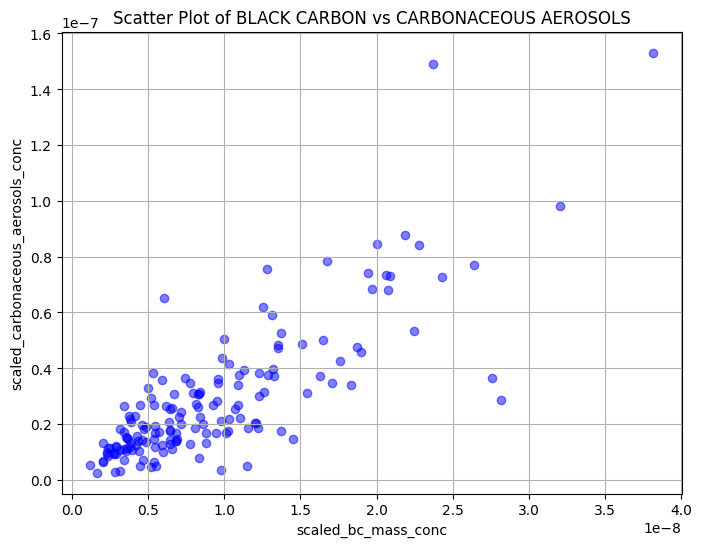

In [9]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))
plt.scatter(A['scaled_bc_mass_conc'], A['scaled_carbonaceous_aerosols_conc'], color='blue', alpha=0.5)
plt.title('Scatter Plot of BLACK CARBON vs CARBONACEOUS AEROSOLS')
plt.xlabel('scaled_bc_mass_conc')
plt.ylabel('scaled_carbonaceous_aerosols_conc')
plt.grid(True)
plt.show()

# REGRESSION COEFFICIENT

In [10]:
from sklearn.linear_model import LinearRegression
x = A[['scaled_bc_mass_conc']]  
y = A['scaled_carbonaceous_aerosols_conc']  
model = LinearRegression()
model.fit(x, y)
coefficients = model.coef_
intercept = model.intercept_
print("Coefficients:", coefficients)
print("Intercept:", intercept)

Coefficients: [2.96599257]
Intercept: 1.246628922309935e-09


# R^2 AND RMSE

In [11]:
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np
y_pred = model.predict(x)
r_squared = r2_score(y, y_pred)
rmse = np.sqrt(mean_squared_error(y, y_pred))
print("R-squared:", r_squared)
print("RMSE:", rmse)

R-squared: 0.649694500704199
RMSE: 1.4379977729341145e-08


# R^2 BY TRAIN AND SPLIT TEST

In [12]:
x= A['scaled_bc_mass_conc'].array.reshape(-1, 1)
y = A['scaled_carbonaceous_aerosols_conc']  


In [13]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score,mean_absolute_error,mean_squared_error
xtrain,xtest,ytrain,ytest=train_test_split(x,y,test_size=0.2,random_state=14)
from sklearn.linear_model import LinearRegression
import numpy as np
lm=LinearRegression()
model=lm.fit(xtrain,ytrain)
y_pred=model.predict(xtest)
bo=model.coef_
b1=model.intercept_
r_squared = r2_score(ytest, y_pred)
n = len(ytest) + len(ytrain) 
p = xtrain.shape[1]  
adjusted_r_squared = 1 - ((n - 1) / (n - p - 1)) * (1 - r_squared)

mse = mean_squared_error(ytest, y_pred)
mae = mean_absolute_error(ytest, y_pred)
rmse = np.sqrt(mse)
tr_pred=model.predict(xtrain)
ts_pred=model.predict(xtest)
train_err=mean_absolute_error(ytrain,tr_pred)
test_err=mean_absolute_error(ytest,ts_pred)

In [14]:
r_squared

0.8843499800354245

In [15]:
bo


array([2.92906098])

In [16]:
b1

np.float64(1.7092255585059054e-09)

# SCATTER PLOT WITH REGRESSION LINE

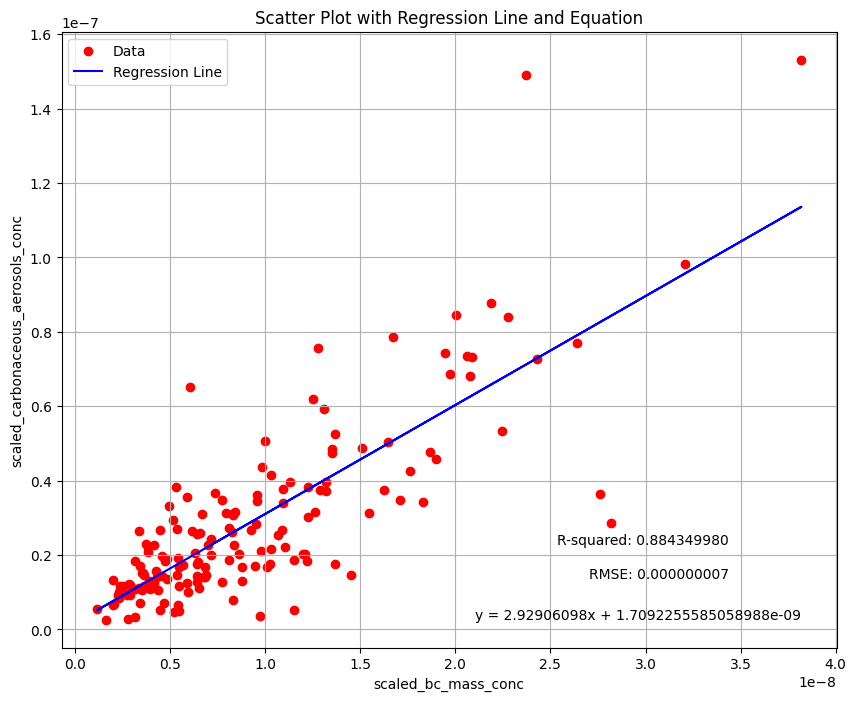

In [17]:
import matplotlib.pyplot as plt
x= A['scaled_bc_mass_conc']
y = A['scaled_carbonaceous_aerosols_conc']  
bo = 2.92906098 
b1 = 1.7092255585058988e-09
regression_line = bo * x + b1

plt.figure(figsize=(10, 8))
plt.scatter(x, y, color='red', label='Data')
plt.plot(x, regression_line, color='blue', label='Regression Line')
equation = f'y = {bo}x + {b1}'
plt.text(x.max() * 1.0, y.min() * 1.0, equation, fontsize=10, color='black', ha='right')
plt.text(x.max() * 0.90, y.max() * 0.15, f'R-squared: {r_squared:.9f}', fontsize=10, color='black', ha='right')
plt.text(x.max() * 0.90, y.max() * 0.09, f'RMSE: {rmse:.9f}', fontsize=10, color='black', ha='right')

plt.title('Scatter Plot with Regression Line and Equation')
plt.xlabel('scaled_bc_mass_conc')
plt.ylabel('scaled_carbonaceous_aerosols_conc')
plt.legend()
plt.grid(True)
plt.show()

# TREND ANALYSIS FOR WHOLE DATA

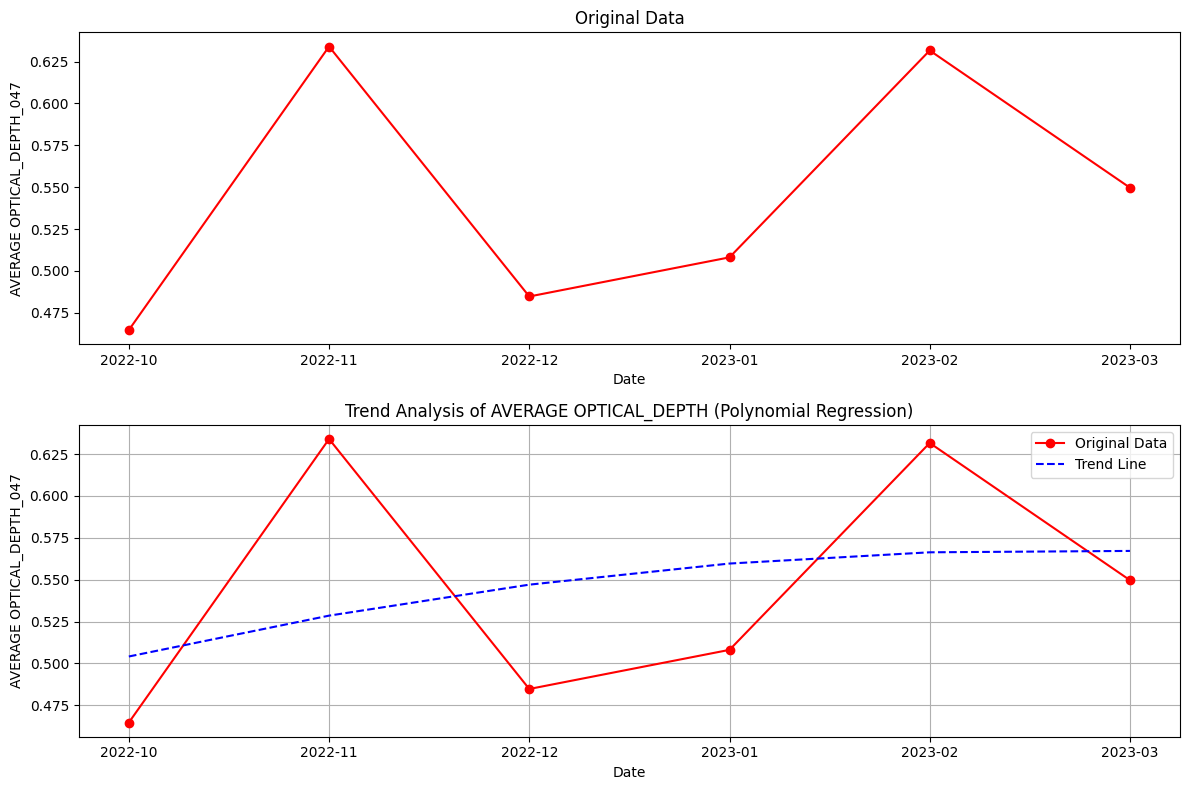

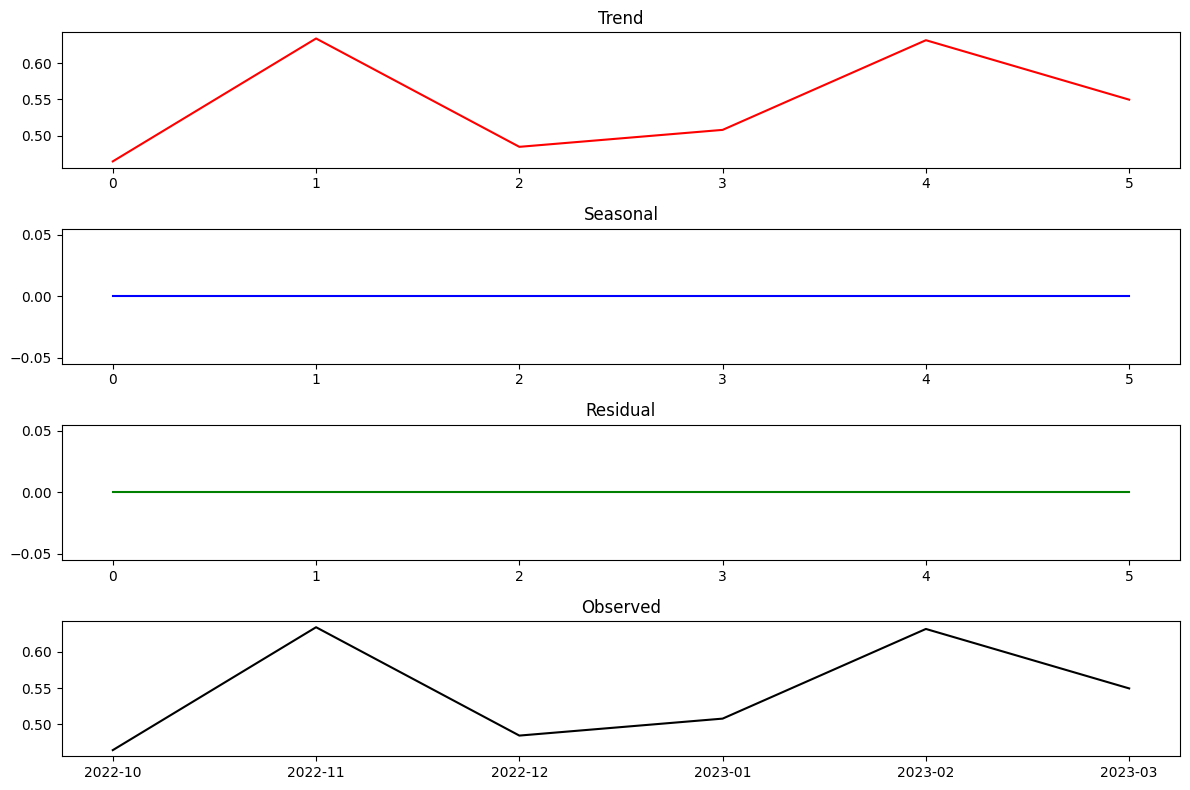

In [18]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose


A['DATE'] = pd.to_datetime(A['DATE'], format='%d-%m-%Y')
A = A.sort_values(by='DATE')
A['YearMonth'] = A['DATE'].dt.to_period('M')
A_monthly_mean = A.groupby('YearMonth').mean()
A_monthly_mean = A_monthly_mean.reset_index()
X = np.array(range(len(A_monthly_mean))).reshape(-1, 1)
y = A_monthly_mean['AVERAGE OPTICAL_DEPTH_047']
degree = 2  

poly = PolynomialFeatures(degree=degree)
X_poly = poly.fit_transform(X)
model = LinearRegression()
model.fit(X_poly, y)

A_monthly_mean['YearMonth'] = A_monthly_mean['YearMonth'].astype(str)
plt.figure(figsize=(12, 8))
plt.subplot(2, 1, 1)
plt.plot(A_monthly_mean['YearMonth'], A_monthly_mean['AVERAGE OPTICAL_DEPTH_047'], marker='o', color='red')
plt.title('Original Data')
plt.xlabel('Date')
plt.ylabel('AVERAGE OPTICAL_DEPTH_047')
plt.subplot(2, 1, 2)
plt.plot(A_monthly_mean['YearMonth'], A_monthly_mean['AVERAGE OPTICAL_DEPTH_047'], marker='o', color='red', label='Original Data')


X_sorted = np.array(range(len(A_monthly_mean) + 5)).reshape(-1, 1)
X_sorted_poly = poly.transform(X_sorted)
y_pred = model.predict(X_sorted_poly)


plt.plot(A_monthly_mean['YearMonth'], y_pred[:len(A_monthly_mean)], color='blue', linestyle='--', label='Trend Line')
plt.xlabel('Date')
plt.ylabel('AVERAGE OPTICAL_DEPTH_047')
plt.title('Trend Analysis of AVERAGE OPTICAL_DEPTH (Polynomial Regression)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



decomposition = seasonal_decompose(A_monthly_mean['AVERAGE OPTICAL_DEPTH_047'], model='additive', period=1)
plt.figure(figsize=(12, 8))
plt.subplot(4, 1, 1)
plt.plot(decomposition.trend, color='red')
plt.title('Trend')
plt.subplot(4, 1, 2)
plt.plot(decomposition.seasonal, color='blue')
plt.title('Seasonal')
plt.subplot(4, 1, 3)
plt.plot(decomposition.resid, color='green')
plt.title('Residual')
plt.subplot(4, 1, 4)
plt.plot(A_monthly_mean['YearMonth'], A_monthly_mean['AVERAGE OPTICAL_DEPTH_047'], color='black')
plt.title('Observed')
plt.tight_layout()
plt.show()

# COMPLETE ANALYSIS GRAPH OF AOD

#### line graph

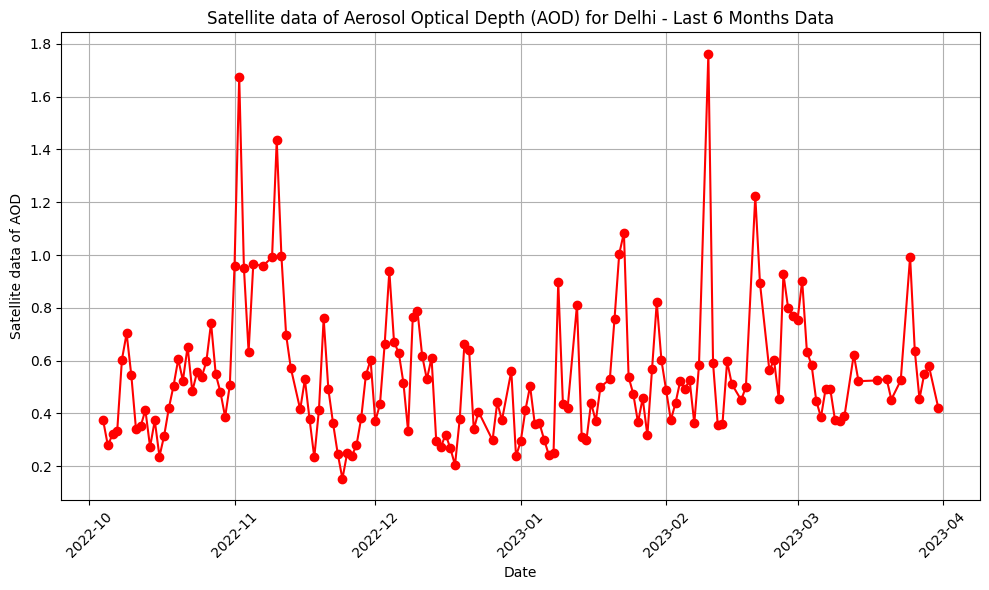

In [19]:
import pandas as pd
import matplotlib.pyplot as plt

data = pd.read_csv("FINAL_CSVFILE_OF_ALL_DATA.csv")
data = data.dropna()
data['DATE'] = pd.to_datetime(data['DATE'], format='%d-%m-%Y')

plt.figure(figsize=(10, 6))
plt.plot(data['DATE'], data['AVERAGE OPTICAL_DEPTH_047'], marker='o', color='r')
plt.title('Satellite data of Aerosol Optical Depth (AOD) for Delhi - Last 6 Months Data')
plt.xlabel('Date')
plt.ylabel('Satellite data of AOD')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#### Bar graph

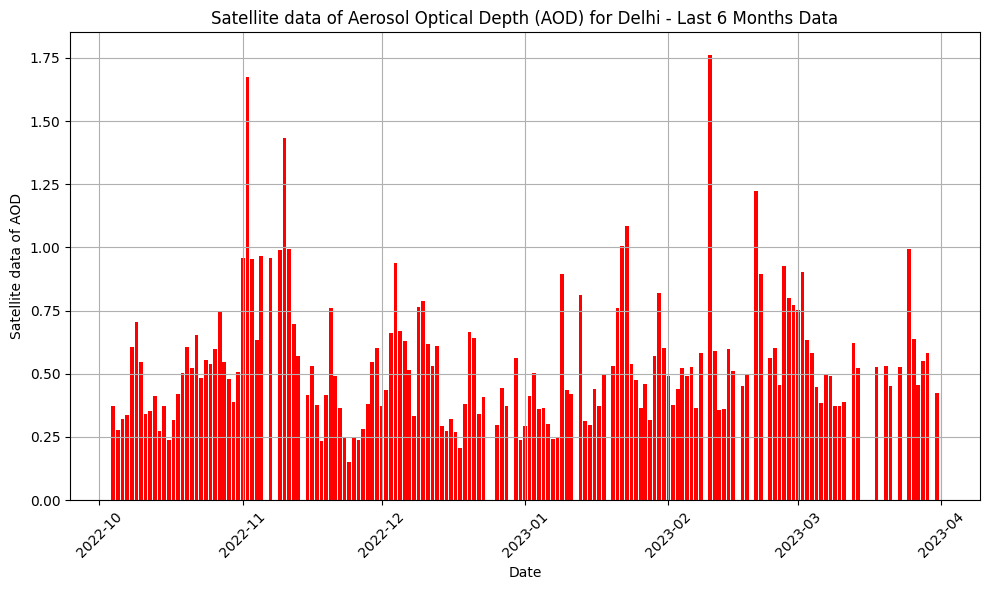

In [20]:
plt.figure(figsize=(10, 6))
plt.bar(data['DATE'], data['AVERAGE OPTICAL_DEPTH_047'], color='r')
plt.title('Satellite data of Aerosol Optical Depth (AOD) for Delhi - Last 6 Months Data')
plt.xlabel('Date')
plt.ylabel('Satellite data of AOD')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


#### Solid line graph

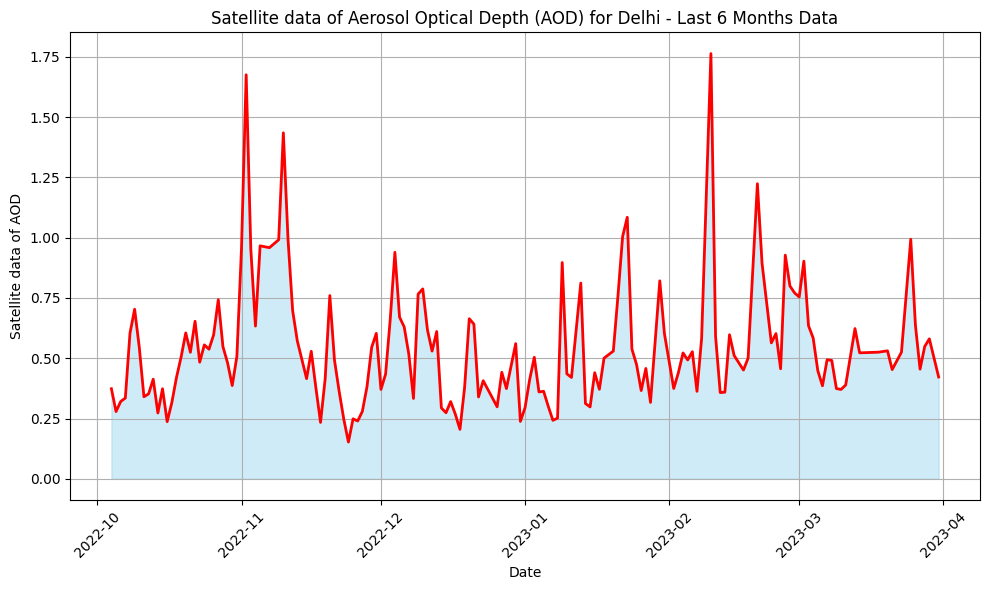

In [21]:
plt.figure(figsize=(10, 6))
plt.fill_between(data['DATE'], data['AVERAGE OPTICAL_DEPTH_047'], color='skyblue', alpha=0.4)
plt.plot(data['DATE'], data['AVERAGE OPTICAL_DEPTH_047'], marker='', color='r', linewidth=2)
plt.title('Satellite data of Aerosol Optical Depth (AOD) for Delhi - Last 6 Months Data')
plt.xlabel('Date')
plt.ylabel('Satellite data of AOD')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# COMPLETE ANALYSIS GRAPH OF MERRA-2

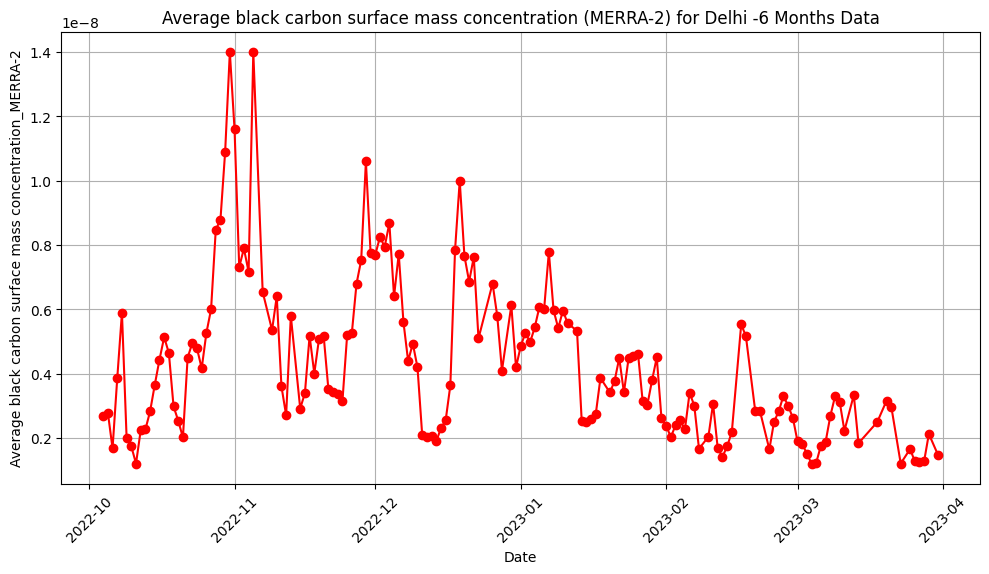

In [22]:
import pandas as pd
import matplotlib.pyplot as plt
data = pd.read_csv("FINAL_CSVFILE_OF_ALL_DATA.csv") 
data = data.dropna()
data['DATE'] = pd.to_datetime(data['DATE'], format='%d-%m-%Y')

plt.figure(figsize=(10, 6))
plt.plot(data['DATE'], data['average_merra2(kg/m^3)_(M2T1NXAER v5.12.4)'], marker='o', color='r')
plt.title('Average black carbon surface mass concentration (MERRA-2) for Delhi -6 Months Data')
plt.xlabel('Date')
plt.ylabel('Average black carbon surface mass concentration_MERRA-2')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#### Bar graph

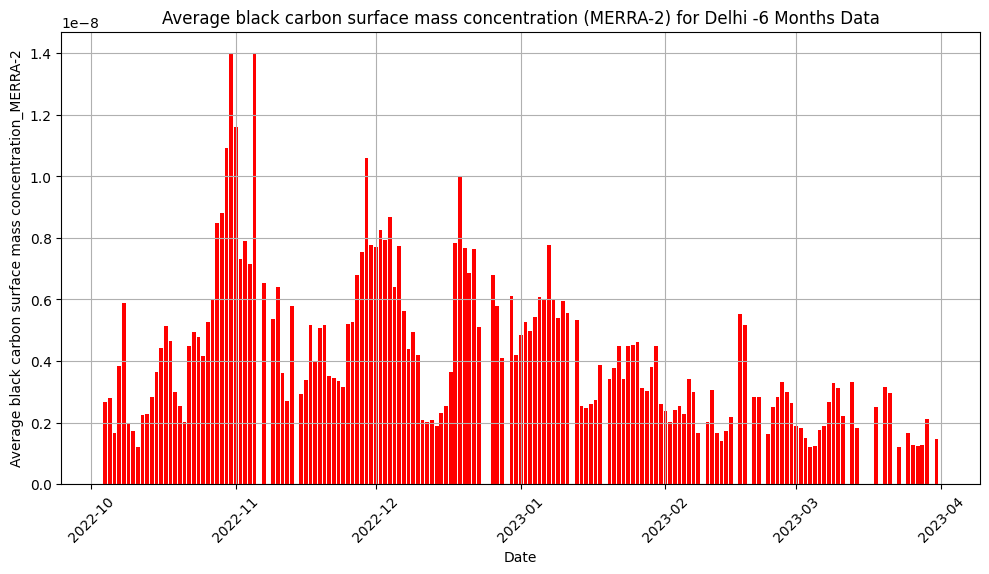

In [23]:
plt.figure(figsize=(10, 6))
plt.bar(data['DATE'], data['average_merra2(kg/m^3)_(M2T1NXAER v5.12.4)'], color='r')
plt.title('Average black carbon surface mass concentration (MERRA-2) for Delhi -6 Months Data')
plt.xlabel('Date')
plt.ylabel('Average black carbon surface mass concentration_MERRA-2')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# MONTHWISE  ANALYSIS GRAPH

#### Line chart

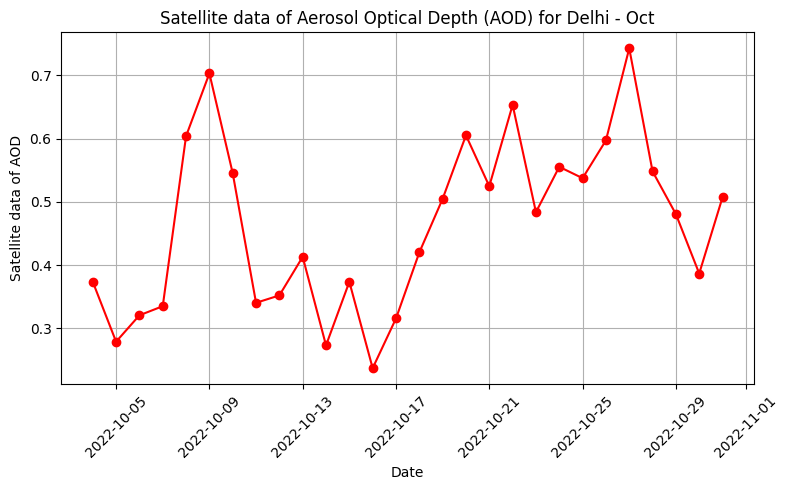

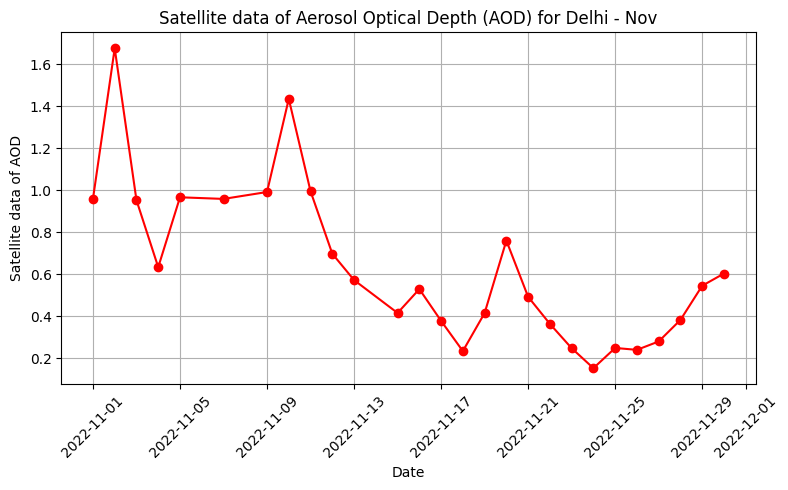

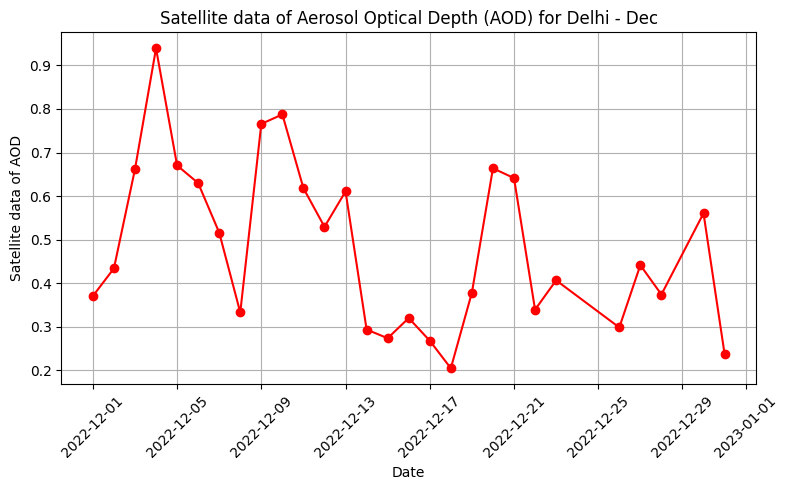

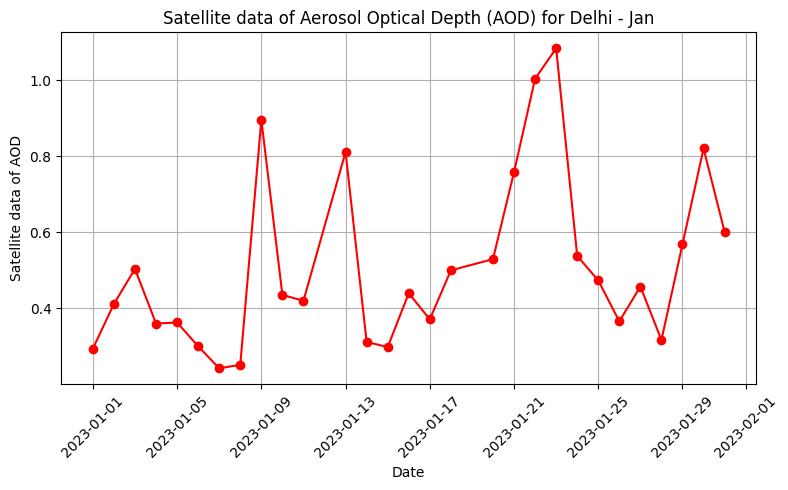

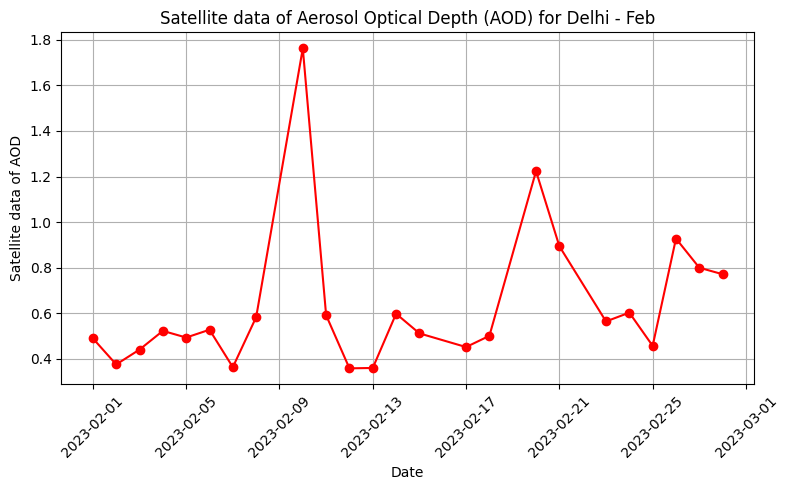

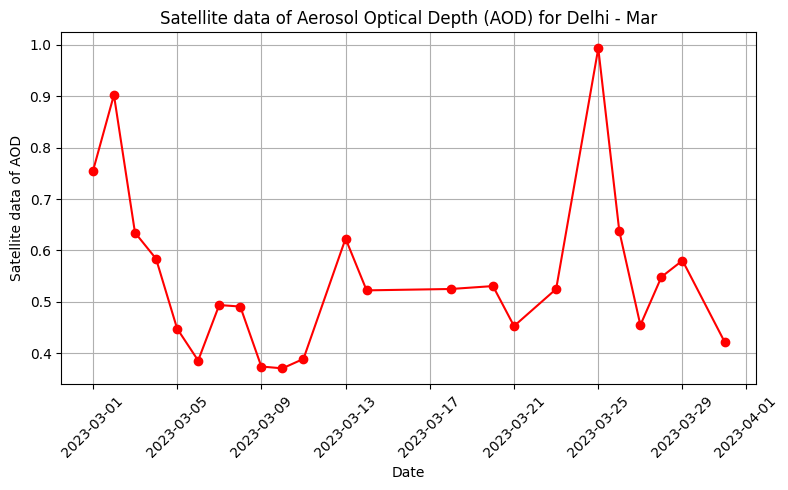

In [24]:
import pandas as pd
import matplotlib.pyplot as plt
data = pd.read_csv("FINAL_CSVFILE_OF_ALL_DATA.csv")  
data=data.dropna()
data['DATE'] = pd.to_datetime(data['DATE'], format='%d-%m-%Y')
data['Month'] = data['DATE'].dt.month
months = [10, 11, 12, 1, 2, 3]
month_names = ['Oct', 'Nov', 'Dec', 'Jan', 'Feb', 'Mar']

for month, month_name in zip(months, month_names):
    month_data = data[data['Month'] == month]
    plt.figure(figsize=(8, 5))
    plt.plot(month_data['DATE'], month_data['AVERAGE OPTICAL_DEPTH_047'], marker='o', color='r')
    plt.title(f'Satellite data of Aerosol Optical Depth (AOD) for Delhi - {month_name}')
    plt.xlabel('Date')
    plt.ylabel('Satellite data of AOD')
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

#### Bar graph

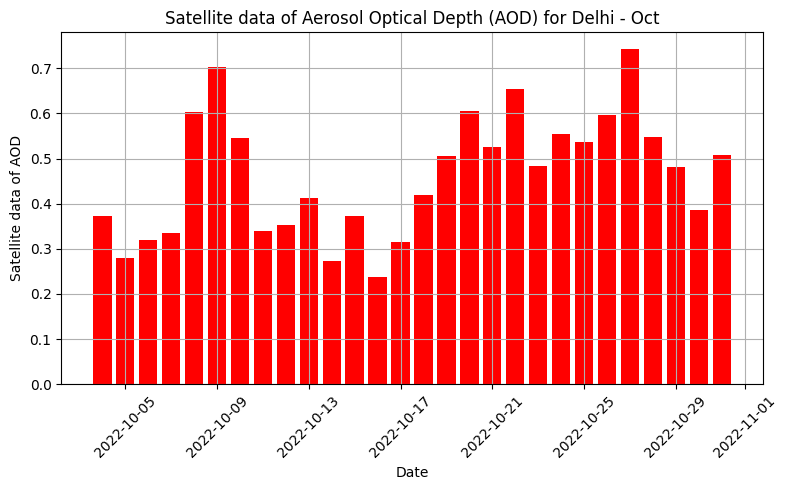

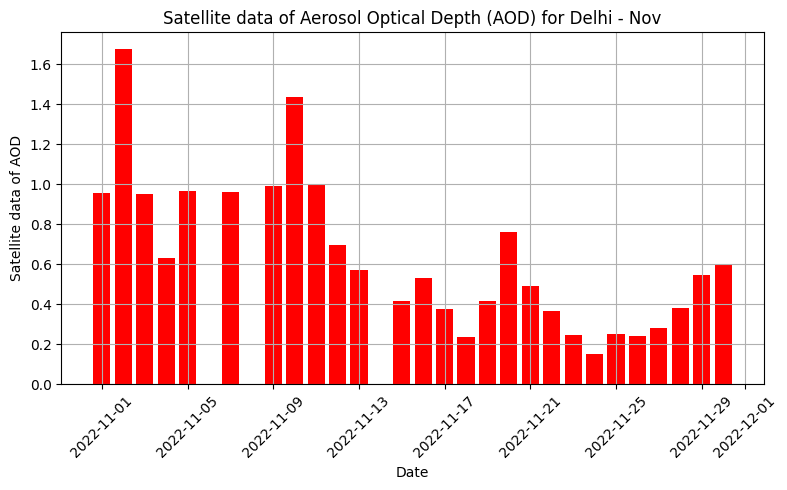

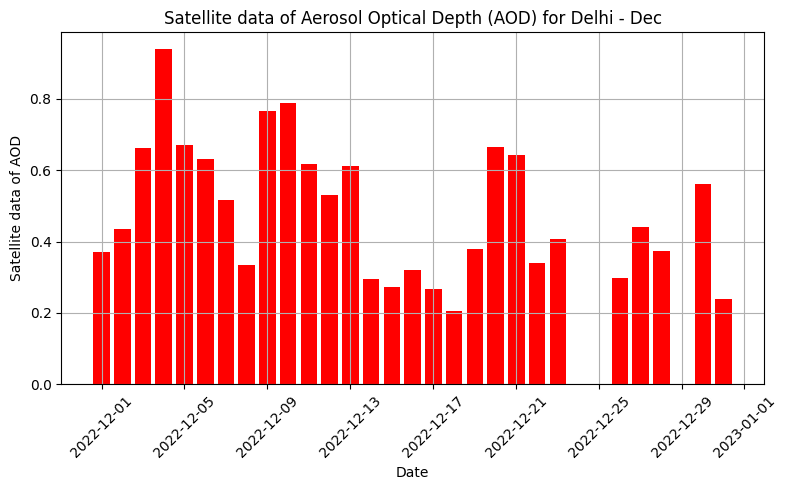

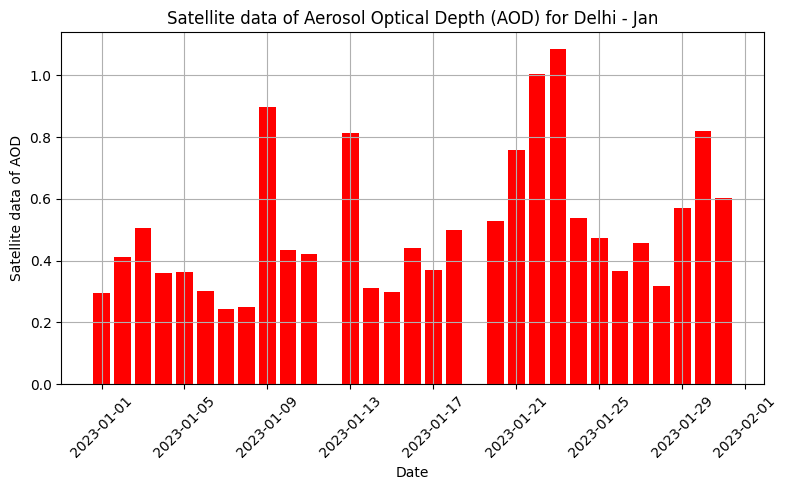

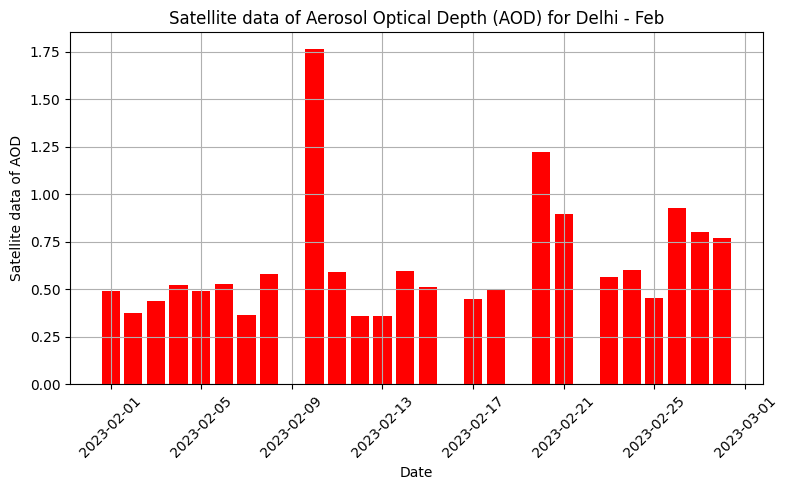

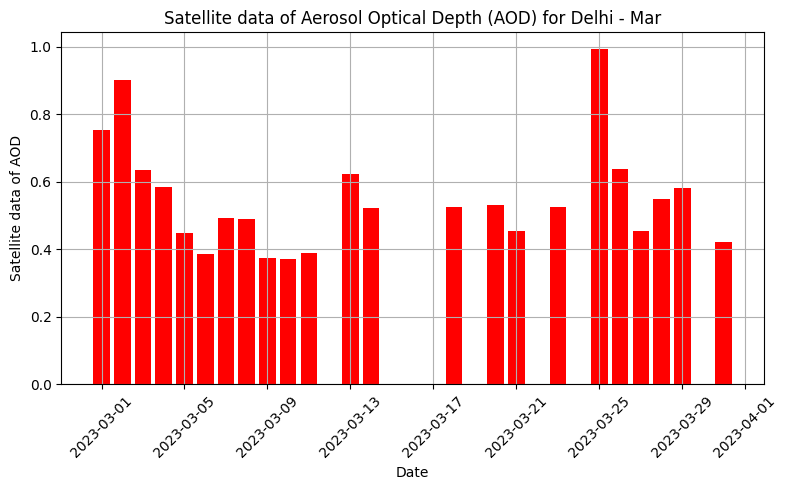

In [25]:
import pandas as pd
import matplotlib.pyplot as plt
data = pd.read_csv("FINAL_CSVFILE_OF_ALL_DATA.csv")  
data=data.dropna()
data['DATE'] = pd.to_datetime(data['DATE'], format='%d-%m-%Y')
data['Month'] = data['DATE'].dt.month
months = [10, 11, 12, 1, 2, 3]
month_names = ['Oct', 'Nov', 'Dec', 'Jan', 'Feb', 'Mar'] 

for month, month_name in zip(months, month_names):
    month_data = data[data['Month'] == month]
    plt.figure(figsize=(8, 5))
    plt.bar(month_data['DATE'], month_data['AVERAGE OPTICAL_DEPTH_047'], color='r')
    plt.title(f'Satellite data of Aerosol Optical Depth (AOD) for Delhi - {month_name}')
    plt.xlabel('Date')
    plt.ylabel('Satellite data of AOD')
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Fire data analysis

In [27]:
import pandas as pd
F=pd.read_csv("fire_count_final data.csv");F

,Unnamed: 0,DATE,AVERAGE OPTICAL_DEPTH_047,GROUND DATA AVERAGE(ng/m^3),carbonaceous_aerosols_470(kg/m^3),average_merra2(kg/m^3)_(M2T1NXAER v5.12.4),fire_count
0,0,01-10-2022,0.188398,NaN,NaN,3.500000e-09,1.0
1,1,02-10-2022,0.242980,NaN,NaN,3.610000e-09,NaN
2,2,03-10-2022,0.222058,NaN,NaN,1.860000e-09,12.0
3,3,04-10-2022,0.373552,9039.717262,9.040000e-09,2.670000e-09,NaN
4,4,05-10-2022,0.278813,14072.437800,1.410000e-08,2.780000e-09,23.0
...,...,...,...,...,...,...,...
87,87,27-12-2022,0.441679,26068.929700,2.610000e-08,5.790000e-09,13.0
88,88,28-12-2022,0.374190,14110.244940,1.410000e-08,4.090000e-09,3.0
89,89,29-12-2022,NaN,18608.031550,1.860000e-08,4.340000e-09,1.0
90,90,30-12-2022,0.560640,19009.147810,1.900000e-08,6.120000e-09,NaN


In [28]:
F=F.dropna();F

,Unnamed: 0,DATE,AVERAGE OPTICAL_DEPTH_047,GROUND DATA AVERAGE(ng/m^3),carbonaceous_aerosols_470(kg/m^3),average_merra2(kg/m^3)_(M2T1NXAER v5.12.4),fire_count
4,4,05-10-2022,0.278813,14072.437800,1.410000e-08,2.780000e-09,23.0
5,5,06-10-2022,0.320570,1494.687500,1.490000e-09,1.670000e-09,1.0
6,6,07-10-2022,0.334944,1722.737500,1.720000e-09,3.850000e-09,1.0
7,7,08-10-2022,0.603907,2199.530357,2.200000e-09,5.890000e-09,1.0
8,8,09-10-2022,0.703091,2040.795833,2.040000e-09,1.980000e-09,1.0
...,...,...,...,...,...,...,...
80,80,20-12-2022,0.663866,12428.491670,1.240000e-08,7.660000e-09,1.0
82,82,22-12-2022,0.339444,18079.341070,1.810000e-08,7.620000e-09,7.0
83,83,23-12-2022,0.406818,25226.738390,2.520000e-08,5.090000e-09,4.0
87,87,27-12-2022,0.441679,26068.929700,2.610000e-08,5.790000e-09,13.0


# Analysis of Black Carbon Surface Mass Concentration from AOD and variation due to fire count

<Figure size 1000x600 with 0 Axes>

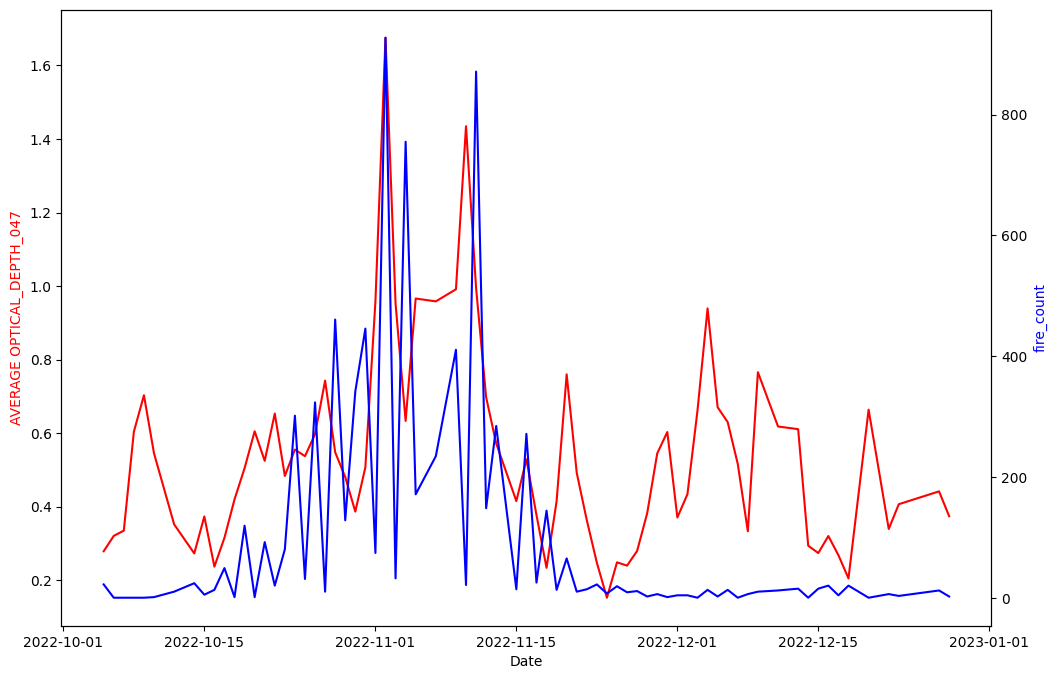

In [30]:
import pandas as pd
import matplotlib.pyplot as plt
F['DATE'] = pd.to_datetime(F['DATE'], format='%d-%m-%Y')
F_oct_dec = F[(F['DATE'] >= '2022-10-05') & (F['DATE'] <= '2022-12-28')]
F_oct_dec.set_index('DATE', inplace=True)

plt.figure(figsize=(10, 6))
x = F_oct_dec.index
y1 = F_oct_dec['AVERAGE OPTICAL_DEPTH_047']
y2 = F_oct_dec['fire_count']
fig, ax1 = plt.subplots(figsize=(12, 8))
ax2 = ax1.twinx()
curve1 = ax1.plot(x, y1, label='AVERAGE OPTICAL_DEPTH_047', color='r')
curve2 = ax2.plot(x, y2, label='fire_count', color='b')
ax1.set_xlabel('Date')
ax1.set_ylabel('AVERAGE OPTICAL_DEPTH_047', color='r')
ax2.set_ylabel('fire_count', color='b')
plt.show()

# Analysis of Black Carbon Surface Mass Concentration from MERRA-2 and variation due to fire

<Figure size 1000x600 with 0 Axes>

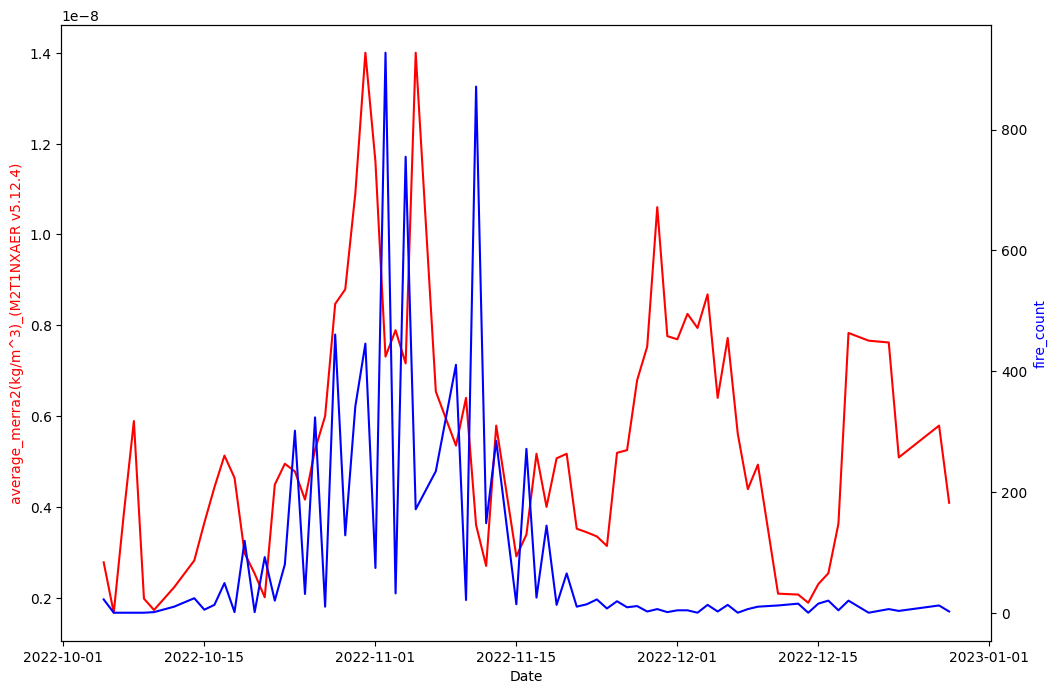

In [31]:
import pandas as pd
import matplotlib.pyplot as plt
F['DATE'] = pd.to_datetime(F['DATE'], format='%d-%m-%Y')
F_oct_dec = F[(F['DATE'] >= '2022-10-05') & (F['DATE'] <= '2022-12-28')]
F_oct_dec.set_index('DATE', inplace=True)
plt.figure(figsize=(10, 6))
x = F_oct_dec.index
y1 = F_oct_dec['average_merra2(kg/m^3)_(M2T1NXAER v5.12.4)']
y2 = F_oct_dec['fire_count']
fig, ax1 = plt.subplots(figsize=(12, 8))
ax2 = ax1.twinx()
curve1 = ax1.plot(x, y1, label='average_merra2(kg/m^3)_(M2T1NXAER v5.12.4)', color='r')
curve2 = ax2.plot(x, y2, label='fire_count', color='b')
ax1.set_xlabel('Date')
ax1.set_ylabel('average_merra2(kg/m^3)_(M2T1NXAER v5.12.4)', color='r')
ax2.set_ylabel('fire_count', color='b')
plt.show()

# Conclusion

### High-resolution AOD at 470 nm effectively captures fine particulate pollution trends in Delhi, with machine learning and BC data aiding in source identification and seasonal impact analysis.
